In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True


In [2]:
path = r"C:\Users\aysen\OneDrive\Masaüstü\data mining proje factorio\analysis_ready_factorio.csv"
df = pd.read_csv(path)

print("rows:", len(df), "cols:", df.shape[1])
print("tick min max:", df["tick"].min(), df["tick"].max())
print("time_s min max:", df["time_s"].min(), df["time_s"].max())
df.head(3)


rows: 365 cols: 517
tick min max: 2268000 3578400
time_s min max: 37800 59640


,tick,time_s,pollution,buildings__boiler,buildings__offshore-pump,buildings__assembling-machine-1,buildings__burner-mining-drill,buildings__stone-furnace,buildings__electric-mining-drill,buildings__lab,...,max_item_rate,share_max,imbalance_std,dominant_item,dominant_rate,tp_z,p_z,share_z,imb_z,bottleneck_score
0,2268000,37800,10283.864837,3,1,47,NaN,192,66,20,...,745.0,0.270417,230.064637,production__iron-plate_per_min,745.0,NaN,NaN,-0.801517,1.693131,NaN
1,2271600,37860,10349.259889,3,1,47,NaN,192,66,20,...,771.0,0.319255,212.932080,production__iron-ore_per_min,771.0,NaN,NaN,-0.529392,1.443388,NaN
2,2275200,37920,10453.894862,3,1,47,NaN,192,66,20,...,862.0,0.411652,210.343249,production__iron-ore_per_min,862.0,NaN,NaN,-0.014546,1.405650,NaN


In [3]:
prod_rate_cols = [c for c in df.columns if c.startswith("production__") and c.endswith("_per_min")]
print("prod_rate_cols:", len(prod_rate_cols))
print("sample:", prod_rate_cols[:10])

needed = ["tick", "time_s", "logsim_power", "throughput_total_per_min"]
missing = [c for c in needed if c not in df.columns]
print("missing:", missing)

df[["tick","time_s","logsim_power","throughput_total_per_min"]].describe()


prod_rate_cols: 24
sample: ['production__transport-belt_per_min', 'production__inserter_per_min', 'production__pipe_per_min', 'production__stone-furnace_per_min', 'production__wood_per_min', 'production__coal_per_min', 'production__stone_per_min', 'production__iron-ore_per_min', 'production__copper-ore_per_min', 'production__iron-plate_per_min']
missing: []


,tick,time_s,logsim_power,throughput_total_per_min
count,3.650000e+02,365.000000,365.000000,365.000000
mean,2.923200e+06,48720.000000,78465.394521,1247.953425
std,3.798384e+05,6330.639778,26274.507214,796.332901
min,2.268000e+06,37800.000000,26436.000000,56.000000
25%,2.595600e+06,43260.000000,63926.000000,472.000000
50%,2.923200e+06,48720.000000,76960.000000,1303.000000
75%,3.250800e+06,54180.000000,93035.000000,1735.000000
max,3.578400e+06,59640.000000,160000.000000,3364.000000


In [4]:
def zscore(s):
    s = pd.to_numeric(s, errors="coerce")
    return (s - s.mean()) / (s.std(ddof=0) + 1e-9)

df = df.sort_values("tick").reset_index(drop=True)

w = 15
minp = 5

df["tp_ma"] = df["throughput_total_per_min"].rolling(w, min_periods=minp).mean()
df["p_ma"]  = df["logsim_power"].rolling(w, min_periods=minp).mean()

df["tp_ratio"] = df["throughput_total_per_min"] / df["tp_ma"].replace(0, np.nan)
df["p_ratio"]  = df["logsim_power"] / df["p_ma"].replace(0, np.nan)

df["max_item_rate"] = df[prod_rate_cols].max(axis=1)
df["share_max"] = df["max_item_rate"] / df["throughput_total_per_min"].replace(0, np.nan)
df["imbalance_std"] = df[prod_rate_cols].std(axis=1)

df["dominant_item"] = df[prod_rate_cols].idxmax(axis=1)
df["dominant_rate"] = df["max_item_rate"]

df["tp_z"] = zscore(df["tp_ratio"])
df["p_z"]  = zscore(df["p_ratio"])
df["share_z"] = zscore(df["share_max"])
df["imb_z"]   = zscore(df["imbalance_std"])

df["bottleneck_score"] = (-df["tp_z"]) + (0.7*df["p_z"]) + (0.2*df["share_z"]) + (0.2*df["imb_z"])

print("bottleneck_score non null:", df["bottleneck_score"].notna().sum(), "out of", len(df))
df[["tp_ratio","p_ratio","share_max","imbalance_std","bottleneck_score"]].describe()


bottleneck_score non null: 361 out of 365


,tp_ratio,p_ratio,share_max,imbalance_std,bottleneck_score
count,361.000000,361.000000,365.000000,365.000000,361.000000
mean,1.012960,1.007775,0.414263,113.914449,-0.002930
std,0.758516,0.269507,0.179713,68.695007,0.963257
min,0.151307,0.448658,0.191589,11.430952,-7.592151
25%,0.625000,0.852119,0.306798,43.890840,-0.322469
50%,0.936604,0.969872,0.347222,119.970739,-0.033276
75%,1.137164,1.070533,0.455910,149.076572,0.306838
max,7.471060,2.103379,1.000000,272.410067,3.441632


In [5]:
thr = df["bottleneck_score"].quantile(0.95)
bn = df[df["bottleneck_score"] >= thr].copy()

df["is_bn"] = df["bottleneck_score"] >= thr

print("threshold q95:", thr)
print("bn rows:", len(bn))

bn[["tick","time_s","logsim_power","throughput_total_per_min","tp_ratio","p_ratio",
    "share_max","imbalance_std","dominant_item","dominant_rate","bottleneck_score"]].sort_values(
    "bottleneck_score", ascending=False
).head(20)


threshold q95: 1.239497743715182
bn rows: 19


,tick,time_s,logsim_power,throughput_total_per_min,tp_ratio,p_ratio,share_max,imbalance_std,dominant_item,dominant_rate,bottleneck_score
236,3117600,51960,113326.0,289.0,0.440370,2.103379,0.477509,33.521543,production__iron-plate_per_min,138.0,3.441632
234,3110400,51840,95525.0,270.0,0.312717,2.003934,0.518519,31.939140,production__iron-plate_per_min,140.0,3.392597
235,3114000,51900,102983.0,275.0,0.362637,2.048171,0.472727,31.946939,production__iron-plate_per_min,130.0,3.390742
237,3121200,52020,111218.0,296.0,0.501979,1.936082,0.459459,34.372217,production__iron-plate_per_min,136.0,2.907534
240,3132000,52200,107380.0,93.0,0.236160,1.578602,1.000000,18.983546,production__coal_per_min,93.0,2.886203
238,3124800,52080,111783.0,262.0,0.495087,1.830212,0.389313,29.150161,production__iron-plate_per_min,102.0,2.547873
239,3128400,52140,110626.0,177.0,0.380918,1.710336,0.525424,21.459390,production__coal_per_min,93.0,2.516069
241,3135600,52260,104208.0,129.0,0.406257,1.447512,0.682171,18.560858,production__coal_per_min,88.0,1.965258
108,2656800,44280,91400.0,1080.0,1.615638,2.094594,0.347222,86.331515,production__iron-ore_per_min,375.0,1.875972
261,3207600,53460,83849.0,67.0,0.171531,0.992225,1.000000,13.676318,production__coal_per_min,67.0,1.430923


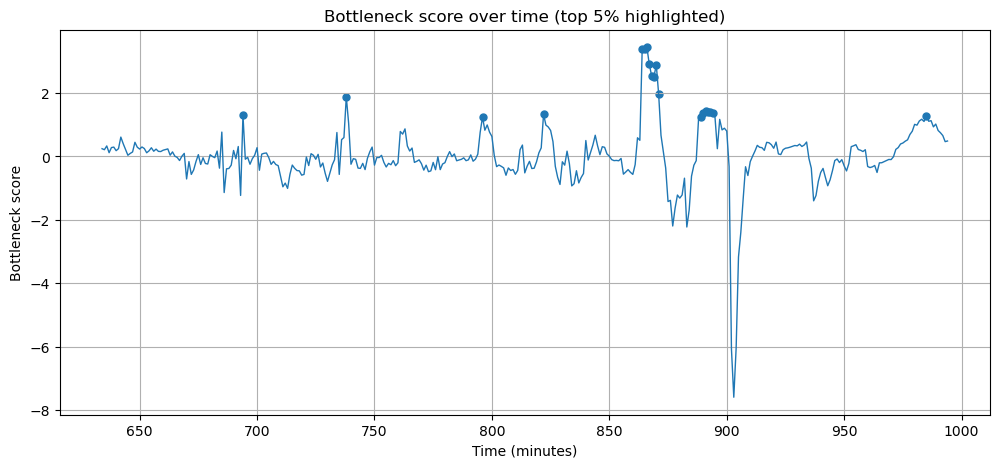

In [6]:
x = df["time_s"] / 60.0

plt.figure()
plt.plot(x, df["bottleneck_score"], linewidth=1)
plt.scatter(x[df["is_bn"]], df.loc[df["is_bn"], "bottleneck_score"], s=25)
plt.xlabel("Time (minutes)")
plt.ylabel("Bottleneck score")
plt.title("Bottleneck score over time (top 5% highlighted)")
plt.show()


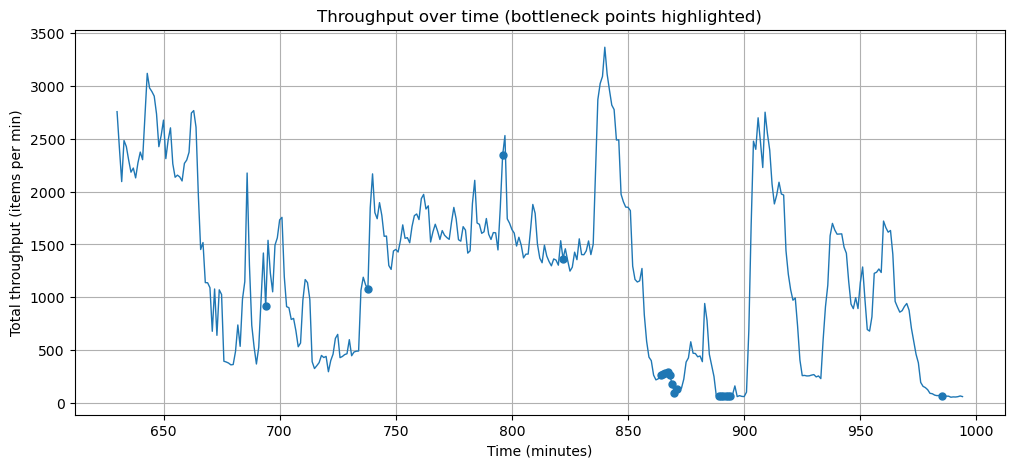

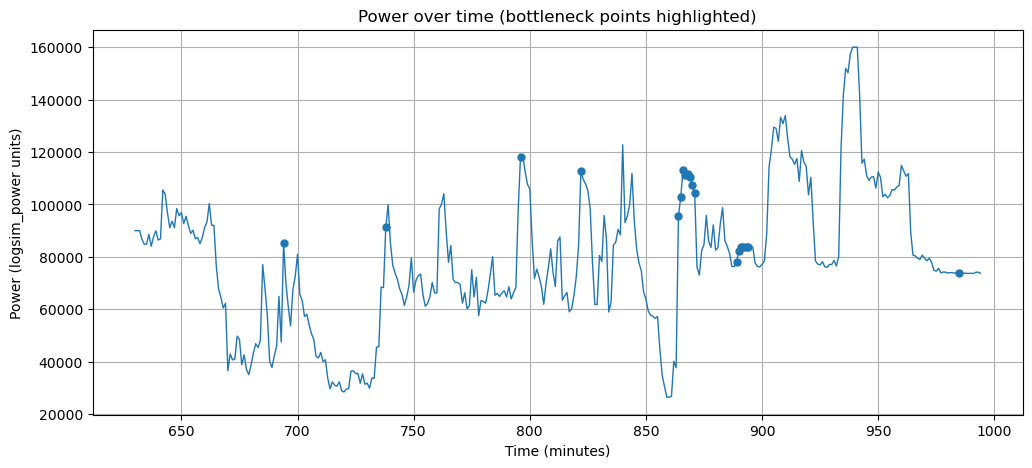

In [7]:
x = df["time_s"] / 60.0

plt.figure()
plt.plot(x, df["throughput_total_per_min"], linewidth=1)
plt.scatter(x[df["is_bn"]], df.loc[df["is_bn"], "throughput_total_per_min"], s=25)
plt.xlabel("Time (minutes)")
plt.ylabel("Total throughput (items per min)")
plt.title("Throughput over time (bottleneck points highlighted)")
plt.show()

plt.figure()
plt.plot(x, df["logsim_power"], linewidth=1)
plt.scatter(x[df["is_bn"]], df.loc[df["is_bn"], "logsim_power"], s=25)
plt.xlabel("Time (minutes)")
plt.ylabel("Power (logsim_power units)")
plt.title("Power over time (bottleneck points highlighted)")
plt.show()


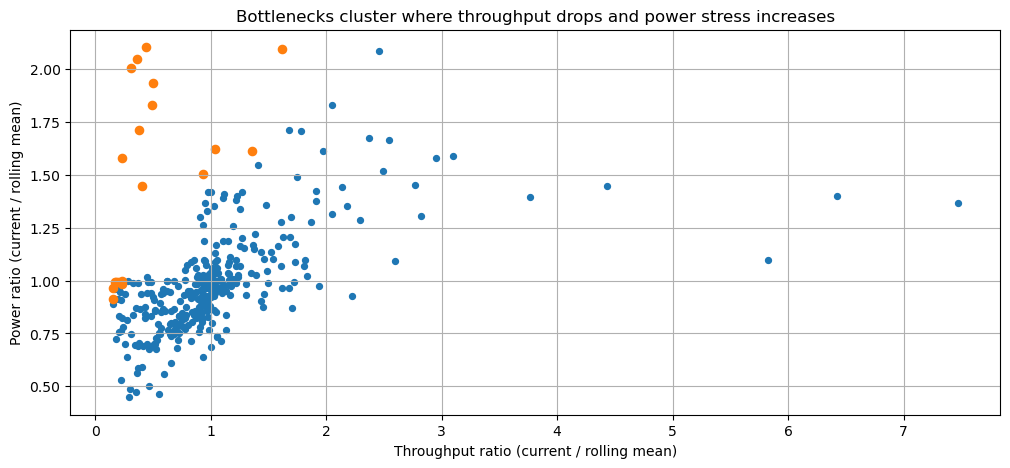

In [8]:
plt.figure()
plt.scatter(df["tp_ratio"], df["p_ratio"], s=18)
plt.scatter(bn["tp_ratio"], bn["p_ratio"], s=35)
plt.xlabel("Throughput ratio (current / rolling mean)")
plt.ylabel("Power ratio (current / rolling mean)")
plt.title("Bottlenecks cluster where throughput drops and power stress increases")
plt.show()


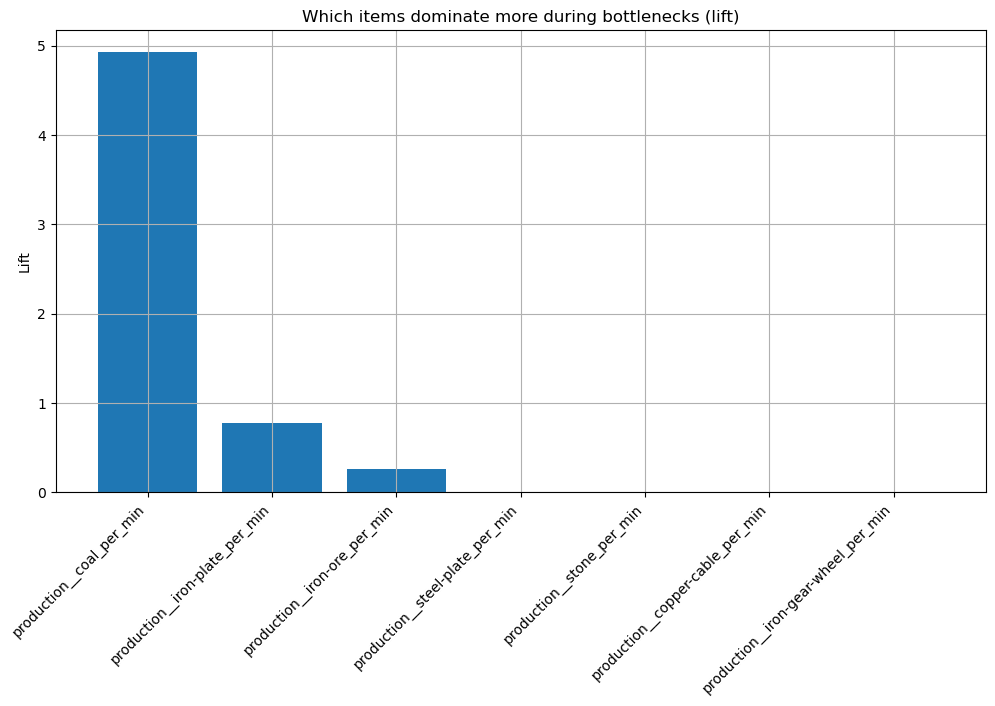

,bn_count,all_count,bn_share,all_share,lift
dominant_item,,,,,
production__coal_per_min,10.0,39,0.526316,0.106849,4.925776e+00
production__iron-plate_per_min,7.0,173,0.368421,0.473973,7.773045e-01
production__iron-ore_per_min,2.0,148,0.105263,0.405479,2.596017e-01
production__steel-plate_per_min,0.0,1,0.000000,0.002740,3.649999e-07
production__stone_per_min,0.0,1,0.000000,0.002740,3.649999e-07
production__copper-cable_per_min,0.0,1,0.000000,0.002740,3.649999e-07
production__iron-gear-wheel_per_min,0.0,2,0.000000,0.005479,1.825000e-07


In [9]:
bn_counts = bn["dominant_item"].value_counts()
all_counts = df["dominant_item"].value_counts()

summary = pd.concat([bn_counts, all_counts], axis=1)
summary.columns = ["bn_count", "all_count"]
summary = summary.fillna(0)

summary["bn_share"] = summary["bn_count"] / (summary["bn_count"].sum() + 1e-9)
summary["all_share"] = summary["all_count"] / (summary["all_count"].sum() + 1e-9)
summary["lift"] = (summary["bn_share"] + 1e-9) / (summary["all_share"] + 1e-9)

top = summary.sort_values("lift", ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(range(len(top)), top["lift"].values)
plt.xticks(range(len(top)), top.index, rotation=45, ha="right")
plt.ylabel("Lift")
plt.title("Which items dominate more during bottlenecks (lift)")
plt.show()

top


In [10]:
def recompute_score(df_sim, prod_cols, w=15, minp=5):
    df_sim = df_sim.sort_values("tick").reset_index(drop=True).copy()

    df_sim["throughput_total_per_min_sim"] = df_sim[prod_cols].sum(axis=1, skipna=True)

    df_sim["tp_ma"] = df_sim["throughput_total_per_min_sim"].rolling(w, min_periods=minp).mean()
    df_sim["p_ma"]  = df_sim["logsim_power"].rolling(w, min_periods=minp).mean()

    df_sim["tp_ratio"] = df_sim["throughput_total_per_min_sim"] / df_sim["tp_ma"].replace(0, np.nan)
    df_sim["p_ratio"]  = df_sim["logsim_power"] / df_sim["p_ma"].replace(0, np.nan)

    df_sim["max_item_rate"] = df_sim[prod_cols].max(axis=1)
    df_sim["share_max"] = df_sim["max_item_rate"] / df_sim["throughput_total_per_min_sim"].replace(0, np.nan)
    df_sim["imbalance_std"] = df_sim[prod_cols].std(axis=1)

    df_sim["tp_z"] = zscore(df_sim["tp_ratio"])
    df_sim["p_z"]  = zscore(df_sim["p_ratio"])
    df_sim["share_z"] = zscore(df_sim["share_max"])
    df_sim["imb_z"]   = zscore(df_sim["imbalance_std"])

    df_sim["bottleneck_score_sim"] = (-df_sim["tp_z"]) + (0.7*df_sim["p_z"]) + (0.2*df_sim["share_z"]) + (0.2*df_sim["imb_z"])
    return df_sim


def simulate_capacity_increase(df_base, prod_cols, item_col, increase_pct=20.0):
    df_sim = df_base.copy()

    mask = df_sim["dominant_item"] == item_col
    factor = 1.0 + increase_pct / 100.0

    df_sim.loc[mask, item_col] = df_sim.loc[mask, item_col] * factor

    df_sim = recompute_score(df_sim, prod_cols)
    return df_sim


In [11]:
top_items = top.index.tolist()
print("top items:", top_items)

base_thr = df["bottleneck_score"].quantile(0.95)
base_bn = (df["bottleneck_score"] >= base_thr).sum()
print("base threshold:", base_thr, "base bn rows:", base_bn)

results = []

for item in top_items[:5]:
    df_sim = simulate_capacity_increase(df, prod_rate_cols, item, increase_pct=20.0)

    thr_sim = df_sim["bottleneck_score_sim"].quantile(0.95)
    bn_sim = (df_sim["bottleneck_score_sim"] >= thr_sim).sum()

    results.append({
        "item": item,
        "increase_pct": 20.0,
        "bn_rows_before": int(base_bn),
        "bn_rows_after": int(bn_sim),
        "delta_bn_rows": int(bn_sim - base_bn),
        "mean_score_before": float(df["bottleneck_score"].mean()),
        "mean_score_after": float(df_sim["bottleneck_score_sim"].mean())
    })

pd.DataFrame(results).sort_values("delta_bn_rows")


top items: ['production__coal_per_min', 'production__iron-plate_per_min', 'production__iron-ore_per_min', 'production__steel-plate_per_min', 'production__stone_per_min', 'production__copper-cable_per_min', 'production__iron-gear-wheel_per_min']
base threshold: 1.239497743715182 base bn rows: 19


,item,increase_pct,bn_rows_before,bn_rows_after,delta_bn_rows,mean_score_before,mean_score_after
0,production__coal_per_min,20.0,19,19,0,-0.00293,-0.002927
1,production__iron-plate_per_min,20.0,19,19,0,-0.00293,-0.002591
2,production__iron-ore_per_min,20.0,19,19,0,-0.00293,-0.003237
3,production__steel-plate_per_min,20.0,19,19,0,-0.00293,-0.002929
4,production__stone_per_min,20.0,19,19,0,-0.00293,-0.002929


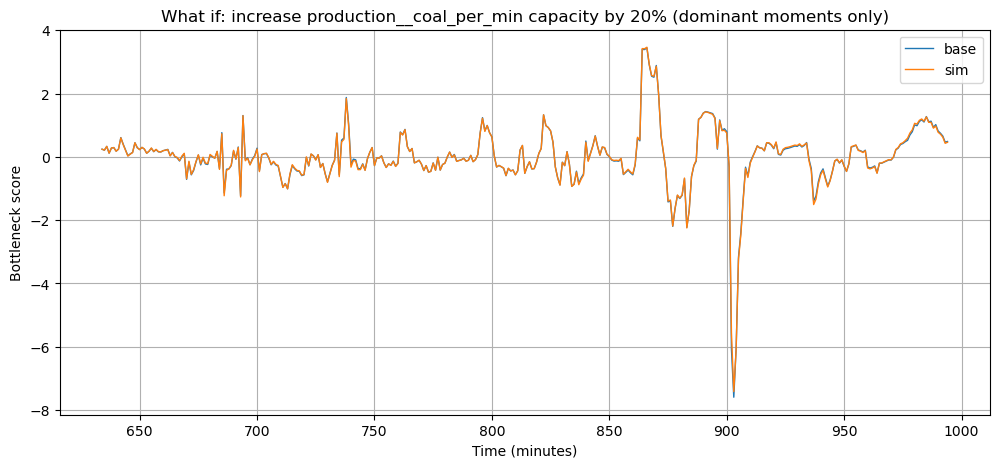

In [12]:
item = top_items[0]
df_sim = simulate_capacity_increase(df, prod_rate_cols, item, increase_pct=20.0)

x = df["time_s"] / 60.0
plt.figure(figsize=(12, 5))
plt.plot(x, df["bottleneck_score"], linewidth=1, label="base")
plt.plot(x, df_sim["bottleneck_score_sim"], linewidth=1, label="sim")
plt.xlabel("Time (minutes)")
plt.ylabel("Bottleneck score")
plt.title(f"What if: increase {item} capacity by 20% (dominant moments only)")
plt.legend()
plt.show()


In [13]:
df_seg = df.copy()
df_seg["bn_flag"] = df_seg["is_bn"].astype(int)
df_seg["bn_change"] = df_seg["bn_flag"].diff().fillna(0)

starts = df_seg.index[df_seg["bn_change"] == 1].tolist()
ends = df_seg.index[df_seg["bn_change"] == -1].tolist()

if df_seg["bn_flag"].iloc[0] == 1:
    starts = [0] + starts
if df_seg["bn_flag"].iloc[-1] == 1:
    ends = ends + [len(df_seg) - 1]

segments = []
for s, e in zip(starts, ends):
    t0 = df_seg.loc[s, "time_s"]
    t1 = df_seg.loc[e, "time_s"]
    segments.append({
        "start_idx": s,
        "end_idx": e,
        "start_min": t0 / 60.0,
        "end_min": t1 / 60.0,
        "duration_min": (t1 - t0) / 60.0,
        "dominant_item_mode": df_seg.loc[s:e, "dominant_item"].mode().iloc[0] if len(df_seg.loc[s:e]) else None,
        "mean_score": df_seg.loc[s:e, "bottleneck_score"].mean()
    })

seg_df = pd.DataFrame(segments).sort_values("duration_min", ascending=False)
seg_df.head(15)


,start_idx,end_idx,start_min,end_min,duration_min,dominant_item_mode,mean_score
4,234,242,864.0,872.0,8.0,production__iron-plate_per_min,2.634830
5,259,265,889.0,895.0,6.0,production__coal_per_min,1.351503
0,64,65,694.0,695.0,1.0,production__iron-ore_per_min,0.607962
2,166,167,796.0,797.0,1.0,production__iron-plate_per_min,1.032473
1,108,109,738.0,739.0,1.0,production__iron-ore_per_min,1.459317
3,192,193,822.0,823.0,1.0,production__iron-ore_per_min,1.157218
6,355,356,985.0,986.0,1.0,production__coal_per_min,1.189990


In [14]:
top2 = summary.sort_values("lift", ascending=False).head(3)

bullets = []
bullets.append(f"Detected {len(bn)} bottleneck moments using a composite score driven by throughput drop, power stress, and production imbalance.")
bullets.append("Bottlenecks concentrate in a small set of dominant items, indicating a structural capacity limitation rather than random fluctuations.")

for item_name, row in top2.iterrows():
    bullets.append(f"{item_name} is over represented during bottlenecks with lift {row['lift']:.2f} and bottleneck share {row['bn_share']:.2%}.")

if len(seg_df) > 0:
    bullets.append(f"Longest bottleneck interval lasts {seg_df['duration_min'].max():.1f} minutes, suggesting sustained constraint rather than short spikes.")

for b in bullets:
    print("•", b)


• Detected 19 bottleneck moments using a composite score driven by throughput drop, power stress, and production imbalance.
• Bottlenecks concentrate in a small set of dominant items, indicating a structural capacity limitation rather than random fluctuations.
• production__coal_per_min is over represented during bottlenecks with lift 4.93 and bottleneck share 52.63%.
• production__iron-plate_per_min is over represented during bottlenecks with lift 0.78 and bottleneck share 36.84%.
• production__iron-ore_per_min is over represented during bottlenecks with lift 0.26 and bottleneck share 10.53%.
• Longest bottleneck interval lasts 8.0 minutes, suggesting sustained constraint rather than short spikes.
